## Data Preparation

In [1]:
# import necessary modules/libraries

import numpy as  np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import pearsonr

from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.7)
sns.set_palette("Greens_r")
#set_palette("Set1", 8, .75) # makes plot lines red

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from sklearn.preprocessing import Imputer # to impute missing data

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

%matplotlib inline

## Feature Engineering

In [17]:
df = pd.read_csv('house_price_prediction.csv') # read the data

df['date'] = pd.to_datetime(df['date']) # change date col to datetime
df['month'] = df['date'].dt.month # creating month feature
df['year'] = df['date'].dt.year  # all 2014 so can drop
df[['waterfront', 'condition']] = df[['waterfront', 'condition']].astype('category') # change data types to categorical
df['state'] = df['statezip'].apply(lambda x: x.split(' ')[0]) # split statezip into state & zipcode
df['zipcode'] = df['statezip'].apply(lambda x: int(x.split(' ')[1]))
df['total_sqft'] = df.sqft_living + df.sqft_lot # creating total_sqft feature: sqft_above + sqft_lot
df['street_name'] = df['street'].str.strip().str.lstrip('-0123456789').str.strip().str.lower()
df['price_is0'] = df['price'] <= 0 # create column of boolean arrays with 1 for price == $0 & 0 for price != $0
df['renov_date_is0'] = df['yr_renovated'] <= 0 # create column of boolean arrays with 1 for yr_renov == 0 & 0 for others

# replacing 0s with the mean bedroom & bathroom values
df["bedrooms"].replace({0: round(df["bedrooms"].mean(), 0)}, inplace=True)
df["bathrooms"].replace({0: round(df["bathrooms"].mean(), 0)}, inplace=True)

In [18]:
for c in ['statezip', 'country', 'state', 'street']:
    try:
        del df[c]
    except KeyError:
        pass

In [19]:
# remove `month` from here and do get_dummies on it after plotting ecdf
df = pd.get_dummies(df, columns=['month', 'zipcode', 'street_name', 'city'])

In [20]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,city_SeaTac,city_Seattle,city_Shoreline,city_Skykomish,city_Snoqualmie,city_Snoqualmie Pass,city_Tukwila,city_Vashon,city_Woodinville,city_Yarrow Point
0,2014-05-02,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,...,0,0,1,0,0,0,0,0,0,0
1,2014-05-02,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,...,0,1,0,0,0,0,0,0,0,0
2,2014-05-02,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
3,2014-05-02,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
4,2014-05-02,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,...,0,0,0,0,0,0,0,0,0,0


**Further feature engineering**

In [21]:
df_no_outs = df[df.price < 10000000].copy() # df with price outliers removed
df_no_zeros = df_no_outs[df_no_outs["price"] != 0].copy() # df with $0 prices removed

df2 = df.copy()
df2['yr_built_is0'] = df2['yr_built'] <= 0
df2['renovation_age'] = df2['year'] - df2['yr_renovated']
df2['house_age'] = df2['year'] - df2['yr_built']
df2['sqft_lot'] = df2[df2['sqft_lot'] < 600000]
df2_no_outs = df[df.price < 10000000].copy() # df2 with price outliers removed
df2_no_zeros = df_no_outs[df_no_outs["price"] != 0].copy() # df2 with $0 prices removed

## Statistical Data Analysis

In [22]:
'''
meanprice_bedrooms = df_no_zeros.groupby('bedrooms')['price'].mean()
medianprice_bedrooms = df_no_zeros.groupby('bedrooms')['price'].median()

meansqft_bedroom = df_no_zeros.groupby("bedrooms")["sqft_living"].mean()
mediansqft_bedroom = df_no_zeros.groupby("bedrooms")["sqft_living"].median()

may_price = df_no_zeros[df_no_zeros.month==5]['price']
june_price = df_no_zeros[df_no_zeros.month==6]['price']
july_price = df_no_zeros[df_no_zeros.month==7]['price']

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)

    x = np.sort(data)

    y = np.arange(1, n+1) / n

    return x, y

# Compute ECDFs
x_5, y_5 = ecdf(may_price)
x_6, y_6 = ecdf(june_price)
x_7, y_7 = ecdf(july_price)
'''

'\nmeanprice_bedrooms = df_no_zeros.groupby(\'bedrooms\')[\'price\'].mean()\nmedianprice_bedrooms = df_no_zeros.groupby(\'bedrooms\')[\'price\'].median()\n\nmeansqft_bedroom = df_no_zeros.groupby("bedrooms")["sqft_living"].mean()\nmediansqft_bedroom = df_no_zeros.groupby("bedrooms")["sqft_living"].median()\n\nmay_price = df_no_zeros[df_no_zeros.month==5][\'price\']\njune_price = df_no_zeros[df_no_zeros.month==6][\'price\']\njuly_price = df_no_zeros[df_no_zeros.month==7][\'price\']\n\ndef ecdf(data):\n    """Compute ECDF for a one-dimensional array of measurements."""\n    n = len(data)\n\n    x = np.sort(data)\n\n    y = np.arange(1, n+1) / n\n\n    return x, y\n\n# Compute ECDFs\nx_5, y_5 = ecdf(may_price)\nx_6, y_6 = ecdf(june_price)\nx_7, y_7 = ecdf(july_price)\n'

### Feature Importance

In [23]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

def feature_importance(X, y, model='reg'):
    score_func = {'reg': f_regression}

    # Score each of the features
    bestfeatures = SelectKBest(score_func=score_func[model], k='all')
    fit = bestfeatures.fit(X, y)

    # Organize and return the scores
    featureScores = pd.DataFrame([X.columns, fit.scores_]).T
    featureScores.columns = ['Feature', 'Score']
    return featureScores.sort_values('Score', ascending=False).set_index('Feature') 

### Hypothesis Test I

**Ho**: Prices of houses with many bedrooms and a few bedrooms are equal.  
**Ha**: Prices of houses with many bedrooms and a few bedrooms are different.

t-test:
I'll compare 2 groups: one with `bedrooms` greater than or equal to 4, and another with less than 4.

In [24]:
many_bedrooms = df_no_outs[df_no_outs['bedrooms'] >= 4]['price']
few_bedrooms = df_no_outs[df_no_outs['bedrooms'] < 4]['price']
stats.ttest_ind(many_bedrooms, few_bedrooms)

Ttest_indResult(statistic=20.612406446603853, pvalue=2.3169170411918228e-90)

#### Result
**t-stat**: 20.6  
**p-val**: 2.3e-90 < 0.05  
We reject the null hypothesis that houses with many bedrooms are priced around the same as houses with fewer bedrooms.

### Hypothesis Test II

**Ho**: Houses with waterfronts are priced the same as houses without waterfronts.  
**Ha**: Houses with waterfronts are priced differently than houses without waterfronts.

In [25]:
waterfront = df_no_outs[df_no_outs['waterfront'] == 1]['price']
no_waterfront = df_no_outs[df_no_outs['waterfront'] == 0]['price']
stats.ttest_ind(waterfront, no_waterfront)

Ttest_indResult(statistic=14.441521571804724, pvalue=2.8817562762538972e-46)

#### Result
**t-stat**: 14.4  
**p-val**: 2.9e-46 < 0.05  
We reject the null hypothesis that houses with waterfronts are priced the same as houses without waterfronts.

# Data Modeling

## Data Preprocessing

In [33]:
# dataframe with both zero prices and outliers.
X = df.drop(['price', 'date', 'year'], axis='columns')
y = df["price"]
# splitting data into training and test data
X_train, X_test, y_train_true, y_test_true = train_test_split(X, y, test_size = 0.3, random_state=42)

# dataframe without price outliers
X_no_outs = df_no_outs.drop(['price', 'date', 'year'], axis='columns')
y_no_outs = df_no_outs["price"]
X_train_no_outs, X_test_no_outs, y_train_no_outs, y_test_no_outs = train_test_split(X_no_outs, y_no_outs, test_size = 0.3, random_state=42)

# dataframe without $0 price values
X_no_zeros = df_no_zeros.drop(['price', 'date', 'year'], axis='columns')
y_no_zeros = df_no_zeros["price"]
X_train_no_zeros, X_test_no_zeros, y_train_no_zeros, y_test_no_zeros = train_test_split(X_no_zeros, y_no_zeros, test_size = 0.3, random_state=42)

# dataframe with a parabolic transformation on the `bedrooms` feature
X_transformed = df_no_zeros.drop(['price', 'date', 'year'], axis='columns')
X_transformed['bedrooms_squared'] = X['bedrooms']**2  # parabolic transformation of bedrooms
y_transformed = df_no_zeros['price']
X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed = train_test_split(X_transformed, y_transformed, test_size = 0.3, random_state=42)

# dataframe with both zero prices and outliers.
X2 = df2.drop(['price', 'date', 'year'], axis='columns')
y2 = df2["price"]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.3, random_state=42)

# dataframe without price outliers
X2_no_outs = df2_no_outs.drop(['price', 'date', 'year'], axis='columns')
y2_no_outs = df2_no_outs["price"]
X2_train_no_outs, X2_test_no_outs, y2_train_no_outs, y2_test_no_outs = train_test_split(X2_no_outs, y2_no_outs, test_size = 0.3, random_state=42)

# dataframe without $0 price values
X2_no_zeros = df2_no_zeros.drop(['price', 'date', 'year'], axis='columns')
y2_no_zeros = df2_no_zeros["price"]
X2_train_no_zeros, X2_test_no_zeros, y2_train_no_zeros, y2_test_no_zeros = train_test_split(X2_no_zeros, y2_no_zeros, test_size = 0.3, random_state=42)

# dataframe with a parabolic transformation on the `bedrooms` feature
X2_transformed = df2_no_zeros.drop(['price', 'date', 'year'], axis='columns')
X2_transformed['bedrooms_squared'] = X2_transformed['bedrooms']**2  # parabolic transformation of bedrooms
y2_transformed = df2_no_zeros['price']
X2_train_transformed, X2_test_transformed, y2_train_transformed, y2_test_transformed = train_test_split(X2_transformed, y2_transformed, test_size = 0.3, random_state=42)


In [27]:
# 4 training sets and test sets
# 3 algorithms

train_test_sets = [
    [X_train, X_test, y_train_true, y_test_true],
    [X_train_no_outs, X_test_no_outs, y_train_no_outs, y_test_no_outs],
    [X_train_no_zeros, X_test_no_zeros, y_train_no_zeros, y_test_no_zeros],
    [X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed],
    [X2_train, X2_test, y2_train, y2_test],
    [X2_train_no_outs, X2_test_no_outs, y2_train_no_outs, y2_test_no_outs],
    [X2_train_no_zeros, X2_test_no_zeros, y2_train_no_zeros, y2_test_no_zeros],
    [X2_train_transformed, X2_test_transformed, y2_train_transformed, y2_test_transformed],
]

train_test_dicts = []
for i, sets in enumerate(train_test_sets):
    d = dict(zip('X_train X_test y_train_true y_test_true'.split(), sets))
    train_test_dicts.append(d)

algorithms = [LinearRegression, Ridge, RandomForestRegressor]
names = ['linear regression', 'ridge regression ', 'random forest    ']

In [28]:
'''
def calc_train_error(X_train, y_train, model):
    #returns in-sample error for already fit model.
    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    rmse = np.sqrt(mse)
    return rmse
    
def calc_test_error(X_test, y_test, model):
    #returns out-of-sample error for already fit model.
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return rmse
    '''

def calc_rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean(y_true - y_pred)**2)
    return rmse
    
def fit_and_score(X_train, y_train_true, X_test, y_test_true, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error, and their accuracy score'''
    
    model.fit(X_train, y_train_true)
    y_train_pred = model.predict(X_train)
    train_error = calc_rmse(y_true=y_train_true, y_pred=y_train_pred)
    y_test_pred = model.predict(X_test)
    test_error = calc_rmse(y_true=y_test_true, y_pred=y_test_pred)
    
    #print(y_train.shape, y_pred.shape)
    
    train_score = model.score(X_train, y_train_true)
    test_score = model.score(X_test, y_test_true)
    
    return train_error, test_error, train_score, test_score, y_train_pred, y_test_pred

### Choosing alpha for Ridge Regression

In [31]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]

for sets in train_test_dicts:
    print('')
    for alpha in alphas:
        model = Ridge(alpha = alpha)
        train_error, test_error, train_score, test_score, y_train_pred, y_test_pred = fit_and_score(model=model, **sets)
        #train_error, test_error, train_score, test_score, y_pred = fit_and_score(sets[0], sets[2],  sets[1], sets[3], model)
        print('alpha: {} | test_score: {} | test_error: {} | test/train error: {}'.format(alpha, test_score, test_error, round(test_error/train_error, 1)))



alpha: 0.0001 | test_score: 0.07617912088939582 | test_error: 28566.35517300306 | test/train error: 338459479266120.2
alpha: 0.001 | test_score: 0.07853034951751338 | test_error: 27887.069950909234 | test/train error: 4479940201405.5
alpha: 0.01 | test_score: 0.08293963903574408 | test_error: 26416.88262616 | test/train error: 12822886435380.7
alpha: 0.1 | test_score: 0.0888537588858156 | test_error: 25387.83019539755 | test/train error: 99647645609803.0
alpha: 1 | test_score: 0.0980933941861637 | test_error: 23232.288498621427 | test/train error: 525210919799374.6
alpha: 10.0 | test_score: 0.09840871488828508 | test_error: 22945.309749708143 | test/train error: 28451699998521.4

alpha: 0.0001 | test_score: 0.5702971105591239 | test_error: 4055.501032359898 | test/train error: 6158197117849.7
alpha: 0.001 | test_score: 0.5777523919863424 | test_error: 4375.531388178785 | test/train error: 3400296045508.8
alpha: 0.01 | test_score: 0.5974661795823368 | test_error: 4872.086406264395 | te

TypeError: float() argument must be a string or a number, not 'Timestamp'

For the 1st & 2nd datasets (df3 & df_no_outs), the best alpha seems to be alpha=1.  
For the 3rd and 4th datasets (df_no_zeros & df_transformed), alpha=0.0001 seems best.

### Choosing parameters for Random Forest

In [32]:
max_depths = [None, 10, 100]
n_estimators = [1, 10, 100, 200]

for sets in train_test_dicts:
    print('')
    for max_depth in max_depths:
        for n in n_estimators:
            model = RandomForestRegressor(max_depth=max_depth , n_estimators=n)
            train_error, test_error, train_score, test_score, y_train_pred, y_test_pred = fit_and_score(model=model, **sets)
            train_error, test_error, train_score, test_score = round(train_error,3), round(test_error,3), round(train_score,3), round(test_score,3)
            print('max_depth: {} | n_estimators: {} | test_score: {} | test_error: {} | test/train error: {}'.format(max_depth, n, test_score, test_error, round(test_error/train_error, 1)))



max_depth: None | n_estimators: 1 | test_score: 0.055 | test_error: 29805.514 | test/train error: 35.2
max_depth: None | n_estimators: 10 | test_score: 0.082 | test_error: 28020.332 | test/train error: 29.4
max_depth: None | n_estimators: 100 | test_score: 0.092 | test_error: 28133.152 | test/train error: 14.3
max_depth: None | n_estimators: 200 | test_score: 0.09 | test_error: 28757.147 | test/train error: 12.1
max_depth: 10 | n_estimators: 1 | test_score: 0.076 | test_error: 28616.931 | test/train error: 6.6
max_depth: 10 | n_estimators: 10 | test_score: 0.075 | test_error: 26546.059 | test/train error: 26.9
max_depth: 10 | n_estimators: 100 | test_score: 0.086 | test_error: 27562.634 | test/train error: 10.9
max_depth: 10 | n_estimators: 200 | test_score: 0.085 | test_error: 28042.651 | test/train error: 11.1
max_depth: 100 | n_estimators: 1 | test_score: 0.065 | test_error: 29462.002 | test/train error: 4.9
max_depth: 100 | n_estimators: 10 | test_score: 0.088 | test_error: 31099.

TypeError: float() argument must be a string or a number, not 'Timestamp'

Looks like the best values for parameters `max_depth` & `n_estimators` are None & 200 respectively.

In [36]:
'''lr_train_score = []
lr_test_score = []
lr_train_error = []
lr_test_error = []

ridge_train_score = []
ridge_test_score = []
ridge_train_error = []
ridge_test_error = []

rf_train_score = []
rf_test_score = []
rf_train_error = []
rf_test_error = []'''

train_score = []
test_score = []
train_error = []
test_error = []
y_train_pred = []
y_test_pred = []

predictions_dict = dict()

for sets in train_test_dicts:
    for model_class, hyperparams in zip(
            [LinearRegression, Ridge, RandomForestRegressor], 
            [{}, dict(alpha=0.0001), dict(max_depth=None, n_estimators=200)]
            ):
        model = model_class(**hyperparams)
        
        train_error, test_error, train_score, test_score, y_train_pred, y_test_pred = fit_and_score(model=model, **sets)
        train_error, test_error, train_score, test_score, y_train_pred, y_test_pred = round(train_error,1), round(test_error,1), round(train_score,0), round(test_score,0), round(y_train_pred,0), round(y_test_pred,0)

        train_error.append(train_error)
        test_error.append(test_error)
        train_score.append(train_score)
        test_score.append(test_score)
        y_train_pred.append(y_train_pred)
        y_test_pred.append(y_test_pred)

        '''for i in range(24):
            if i < 9:
                predictions_dict['lr_pred{}'.format(i)] = y_test_pred
            elif i>=9 and i < 16:
                predictions_dict['ridge_pred{}'.format(i)] = y_test_pred
            else:
                predictions_dict['rf_pred{}'.format(i)] = y_test_pred'''

        

TypeError: type numpy.ndarray doesn't define __round__ method

In [195]:
'''
# constructing table contents 

features = []
for i in range(24):
    features.append('all except date, price, street, city, state')

features_dict = {key: value for key, value in enumerate(features) }


lr = 'linear regression'
ridge = 'ridge regression'
rf = 'random forest'

models = [(lr,)*8, (ridge,)*8, (rf,)*8]


test_error_list = []
for i in range(8):
    test_error_list.append(lr_test_error[i])
for i in range(8):
    test_error_list.append(ridge_test_error[i])
for i in range(8):
    test_error_list.append(rf_test_error[i])
'''

"\n# constructing table contents \n\nfeatures = []\nfor i in range(24):\n    features.append('all except date, price, street, city, state')\n\nfeatures_dict = {key: value for key, value in enumerate(features) }\n\n\nlr = 'linear regression'\nridge = 'ridge regression'\nrf = 'random forest'\n\nmodels = [(lr,)*8, (ridge,)*8, (rf,)*8]\n\n\ntest_error_list = []\nfor i in range(8):\n    test_error_list.append(lr_test_error[i])\nfor i in range(8):\n    test_error_list.append(ridge_test_error[i])\nfor i in range(8):\n    test_error_list.append(rf_test_error[i])\n"

In [184]:
'''
features1 = 'all except date, price, street, city, state'
features2 = 'all except date, price, street, city, state'
features3 = 'all except date, price, street, city, state'
features4 = 'all except date, price, street, city, state'
features5 = 'all except date, price, street, city, state'
features6 = 'all except date, price, street, city, state'
features7 = 'all except date, price, street, city, state'
features8 = 'all except date, price, street, city, state'
features9 = 'all except date, price, street, city, state'
features10 = 'all except date, price, street, city, state'
features11 = 'all except date, price, street, city, state'
features12 = 'all except date, price, street, city, state'
'''


content = {''''features': [features1, features2, features3, features4, features5, features6, features7, features8, 
                        features9, features10, features11, features12],''' 
           'features': [features_dict.values()],
           'model': ['linear regression', 'linear regression', 'linear regression', 'linear regression',
                     'ridge regression', 'ridge regression', 'ridge regression', 'ridge regression', 
                     'random forest', 'random forest', 'random forest', 'random forest'], 
           'test_error': [lr_test_error[0], lr_test_error[1], lr_test_error[2], lr_test_error[3], 
                    ridge_test_error[0], ridge_test_error[1], ridge_test_error[2], ridge_test_error[3], 
                    rf_test_error[0], rf_test_error[1], rf_test_error[2], rf_test_error[3]],
           'train_error': [lr_train_error[0], lr_train_error[1], lr_train_error[2], lr_train_error[3], 
                    ridge_train_error[0], ridge_train_error[1], ridge_train_error[2], ridge_train_error[3], 
                    rf_train_error[0], rf_train_error[1], rf_train_error[2], rf_train_error[3]],
           'test_score': [lr_test_score[0], lr_test_score[1], lr_test_score[2], lr_test_score[3], 
                     ridge_test_score[0], ridge_test_score[1], ridge_test_score[2], ridge_test_score[3],  
                     rf_test_score[0], rf_test_score[1], rf_test_score[2], rf_test_score[3]],
           'train_score': [lr_train_score[0], lr_train_score[1], lr_train_score[2], lr_train_score[3],
                             ridge_train_score[0], ridge_train_score[1], ridge_train_score[2], ridge_train_score[3],
                             rf_train_score[0], rf_train_score[1], rf_train_score[2], rf_train_score[3]],
           'description': ['no transformations', 'no transformations', 'zero prices removed', 'parabolic transformation', 
                           'no transformations', 'no transformations', 'zero prices removed', 'parabolic transformation', 
                           'no transformations', 'no transformations', 'zero prices removed', 'parabolic transformation', 
                            ],
           'price outs removed': ['no', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes']}

table = pd.DataFrame(content, columns=['model', 'test_score', 'train_score', 'test_error', 'train_error', 'price outs removed', 'description', 'features'], index=[1,2,3,4,5,6,7,8,9,10,11,12])
table.sort_values('test_score', ascending=False)

IndexError: list index out of range

Model description:
* Models described as having no transformations are those which did not have their `bedrooms` feature undergo parabolic transformation.
* Models with zero prices removed are those with zero values in the `price` feature and price outliers removed.
* Models with parabolic transformation are based on data with price outliers and zero prices removed, and have their `bedrooms` feature transformed.

From the table above we can see that the best model is the Random Forest with 66% accuracy. That model only has the price outliers removed but not the zero prices. There were also no transformations on the features.

**Analysing the coefficients**

Let's take a look at the coefficients of the best performing ridge regression model that has its `bedrooms` feature transformed.

In [77]:
coefs = pd.DataFrame(ridge.coef_, index=list(X_transformed), columns=['Coef'])
coefs[:18]

,Coef
bedrooms,29343.232043
bathrooms,-4241.088926
sqft_living,121.478954
sqft_lot,-2.771947
floors,-15807.991737
waterfront,418127.945192
view,70032.879065
condition,25114.687333
sqft_above,113.204213
sqft_basement,10.453874


The coefficient of a term represents the change in the mean response for one unit of change in that term. If the coefficient is positive, as the term increases, the mean value of the response increases. If the coefficient is negative, as the term increases, the mean value of the response decreases. So for example we see than the coefficient of `sqft_living` is 180. This means that for every 1 sqft increase on a house, the price would increase by \\$180.

I was surprised to see `bedrooms` have a negative coeficient, since my assumption was that when the number of bedrooms increase, so does the price. However, we saw previously with a `bedrooms` and `price` scatterplot that price increases with number of bedrooms only for homes with up to 5 bedrooms. The price then starts to decrease for homes with 6 bedrooms or more.  
Notice also `bedrooms_squared` has a positive coeficient. This feature is `bedrooms` with a parabolic transformation. Since this feature has adjusted for `bedrooms` shape, it makes sense that it is positive.

Not only is the coefficient of `sqft_lot` negative, but it's also a small number, indicating that its affect on  price is miniscule.

In [14]:
# coefs of fitted model & predicted model
#coefs = pd.DataFrame({'coef_actual': ridge.coef_, 'coef_pred': predictions_dict['ridge_pred3']}, index=list(X_transformed))

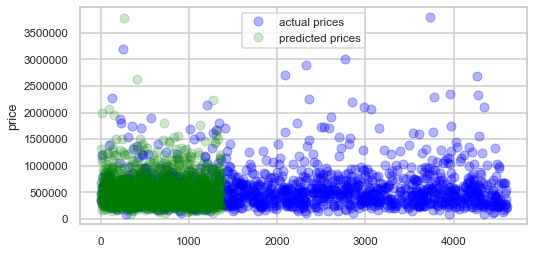

In [15]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_transformed, 'bo', alpha=0.3, label='actual prices')
ax.plot(predictions_dict['lr_pred3'], 'go', alpha=0.2, label='predicted prices')
#ax.set_xlabel('')
ax.set_ylabel('price')
ax.legend()
plt.show()

Text(0, 0.5, 'predicted prices')

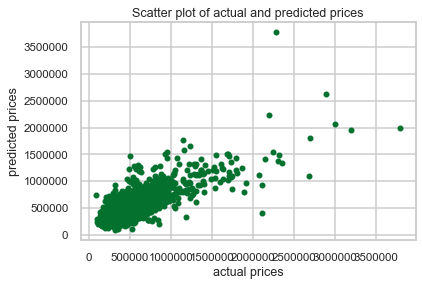

In [16]:
plt.scatter(y_test_transformed, predictions_dict['lr_pred3'], s=20)
plt.title('Scatter plot of actual and predicted prices')
plt.xlabel('actual prices')
plt.ylabel('predicted prices')

We see in the above plot that the predicted prices are somewhat close to the actual prices, but not very close. The best case scenario would be for the scatter plots to follow a perfectly straight diagonal line, indicating that our model perfectly predicted the house prices.

Histogram of the residuals of the best performing linear regression model.

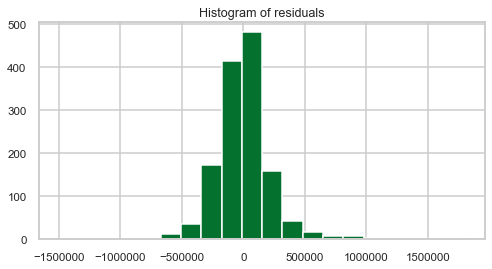

In [17]:
plt.subplots(figsize=(8,4))
plt.hist(y_test_transformed - predictions_dict['lr_pred3'], bins=20)
plt.title('Histogram of residuals')
plt.show()

Ideally a residual histogram would follow a normal distribution, and that would tell us that we've chosen an appropriate model type. However, the above plot does not closely follow a normal distribution, which is another indication that a linear regression model is not best for my dataset.

### CI around my prediction accuracy

calculate standard error RMSE
..

In [18]:
# RMSE == standard deviation of errors
rf_test_error

[815993.804, 218792.665, 221804.67, 221812.353]

In [19]:
one_sd = min(rf_test_error)
two_sd = 2*one_sd
three_sd = 3*one_sd

#### 68% Confidence

In [20]:
min_error = 0 - one_sd
max_error = 0 + one_sd

print('I can be 68% confident that the error in the home price predictions will be between {} and {}.'.format(min_error, max_error))

I can be 68% confident that the error in the home price predictions will be between -218792.665 and 218792.665.


#### 95% Confidence

In [21]:
min_error = 0 - two_sd
max_error = 0 + two_sd

print('I can be 95% confident that the error in the home price predictions will be between {} and {}.'.format(min_error, max_error))

I can be 95% confident that the error in the home price predictions will be between -437585.33 and 437585.33.


### Result Analysis

The following analysis is based on my 95% confidence that the error in the home price predictions is between -429250 and -429250:

If I've predicted a house to be $\$$500,000 and someone were to buy the house at that price, the worst loss would be \\$429250 and the highest gain would be \\$429250. That is, the least the house would be worth is \\$70,750 (500,000-429250), and the most the house would be worth is \\$929,250 (500,000+429250).

Let's say my boss wants to buy a house at below my estimate in the hopes of flipping it, i.e., selling the house at around double the price at which he acquired it. With a house that I have estimated to be \\$500,000, if he purchases it at \\$300,000 for example, 3 things can happen:

1. My estimation is correct and he would make a profit of \\$200,000 by selling it for \\$500,000.  
2. The house is actually worth \\$70,750 and he ends up buying at a higher price than what the house is worth, losing \\$229,250 on the purchase, and resulting in a 24\% loss.
3. The house is actually worth \\$929,250 and he ends up buying \\$629,250 below the house value, resulting in a 309\%  profit if he were to sell it at \\$929,250.

**What happens if my boss purchases 100 homes?**

In [22]:
from math import sqrt

np.random.seed(47)
n = 100 # length of sample

# function to sample the actual and predicted prices of 100 homes at a time.
def draw_bs_reps(y_test, y_pred):
    bs_error = np.random.choice(y_test - y_pred, n) # price sold - price bought == profit (gain or loss)
    
    error_mean = np.sum(bs_error) / len(bs_error) # avg gain or loss on n transactions
    return error_mean

In [28]:
# conducting 1000 experiments of purchasing 100 homes
error_means = np.array([draw_bs_reps(y_test_transformed, predictions_dict['rf_pred3']) for i in range(1000)]) # Random Forest model
error_means = np.round(error_means, 2)
error_means_mean = np.mean(error_means) # mean of means
print('mean of means: {}'.format(int(error_means_mean)))

error_means_std = sqrt(np.sum((error_means-error_means_mean)**2) / (1000-1)) # standard deviation of means
print('std of means: {}'.format(int(error_means_std)))

# confidence interval
min_error_100 = int(error_means_mean - 2*error_means_std)
max_error_100 = int(error_means_mean + 2*error_means_std)

print('')
print('The above result means that if I calculate the error between the true/historical price and my predicted price ' 
      'of 100 homes, I can be 95% confident that the error of the mean of average error in the home price ' 
      'predictions will be between {:,} and {:,}.'.format(min_error*100, max_error*100))
print('')
print('In other words, if my boss was to buy 100 homes at my predicted price and sell them at their true price, ' 
      'I can be 95% confident that the most she would lose is ${:,} ' 
      'and the most she would gain is ${:,}.'.format(-1*min_error_100*100, max_error_100*100))

mean of means: 1817
std of means: 22636

The above result means that if I calculate the error between the true/historical price and my predicted price of 100 homes, I can be 95% confident that the error of the mean of average error in the home price predictions will be between -43,758,533.0 and 43,758,533.0.

In other words, if my boss was to buy 100 homes at my predicted price and sell them at their true price, I can be 95% confident that the most she would lose is $4,345,500 and the most she would gain is $4,709,000.


Below is a histogram of the distribution of purchasing 100 homes at my predicted prices.

-45260 48250


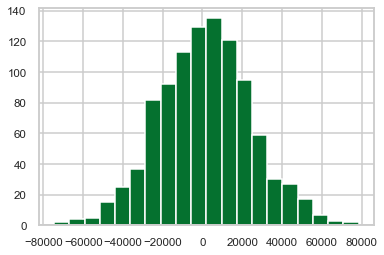

In [24]:
plt.hist(error_means, bins=20)
plt.plot()
print(min_error_100, max_error_100)

It shows that the mode is shifted to the positive, which is good because it means we're profiting. I conducted this experiment a few more times to make sure the shape is real.

What happens if my boss purchases homes $1000 below my predicted prices?

In [25]:
# running the same experiment as before, with $1000 deducted from my predicted prices

np.random.seed(47)
n = 100 # length of sample
N_rep = 1000 # number of times to bootstrap/resample

def draw_bs_reps(y_test, y_pred):
    bs_error = np.random.choice(y_test - (y_pred-1000), n) # deduct 1000 from each predicted price
    
    error_mean = np.sum(bs_error) / len(bs_error) # avg gain or loss on n transactions
    return error_mean

In [26]:
error_means = np.array([draw_bs_reps(y_test_transformed, predictions_dict['rf_pred3']) for i in range(1000)]) # Random Forest model
error_means = np.round(error_means, 2)
error_means_mean = np.mean(error_means) # mean of means
print('mean of means: {}'.format(int(error_means_mean)))

error_means_std = sqrt(np.sum((error_means-error_means_mean)**2) / (1000-1)) # standard deviation of means
print('std of means: {}'.format(int(error_means_std)))

# confidence interval
min_error_1000 = int(error_means_mean - 2*error_means_std)
max_error_1000 = int(error_means_mean + 2*error_means_std)

print('')
print('If my boss was to buy 100 homes at $1000 less than my predicted price and sell them at their true price, ' 
      'I can be 95% confident that the most she would lose is ${:,} ' 
      'and the most she would gain is ${:,}.'.format(-1*min_error_1000*100, max_error_1000*100))

mean of means: 2494
std of means: 23377

If my boss was to buy 100 homes at $1000 less than my predicted price and sell them at their true price, I can be 95% confident that the most she would lose is $4,426,000 and the most she would gain is $4,925,000.


When purchasing 100 homes at \\$1000 below my predicted price, the most my boss would lose decreases by \\$ and the most she would gain increases by \\$.  
This is clearly a better option, and since finding homes that are selling \\$1000 below their true value is practical, I would recommend this plan to my boss.

### Result

Other experiments:
* experiments with other models
* experiemnts with predicted prices reduced by \\$5,000, \\$10,000, \\$50,000

When running experiments using my other models, the Random Forest model resulted in the most profit, which was expected since the model had the least error in its prediction.

I ran experiments with \\$5,000, \\$10,000, \\$50,000 deducted from the predicted prices. 
This means that my boss would purchase 100 homes with \\$5,000, \\$10,000, and \\$50,000 below my predicted prices. 
The result was that these 3 experiments produced better profits and less losses than the scenario where my boss would purchase homes at \\$1000 less than my predicted prices. However, finding 100 houses at those reduced prices would be difficult. Therefore, I would reccomend focusing on finding homes with the \\$1000 reductions.

We did 1000 experiments (it's like we ran this business for 1000 years), each year we bought 100 homes and we sold 100 homes. And we're assuming we could buy them at the predicted price and we'd have to sell them at the true price. 

So we have 1000 examples of us buying 100 homes and selling them at a different price. So think of it as calulating profit (not error). 

So, we're assuming we bought the houses at the predicted price, and we assume we have to sell them at the true price. What we're looking to calculate is at the end of each year, what is the balance sheet going to look like. What's the average loss or gain he's going to make on those homes. 

error_mean == avg. profit on each year

In [27]:
error_means
# each value in error_means is a new year where we bought 100 homes and sold 100 homes 
# and we got this avg price for each one..
# So, if we want to know home much we made at the end of each year, we multipy by 100.
# Some years we'll lose money, some years we'll gain.

# on the 1st year we lost 6282 * 100 = 628,200
# on the 3rd year we gained 6836 * 100 = 683,600

# my boss doesn't care if I lose 300K one year or 30,000, or 3 million. He wants to know what's likely to happen. 
# because he knows my prediction is not going to be 100% correct. 

# do this same simulation with $1000 less than the predicted price and see what happens.


array([-3.159030e+03, -3.000408e+04,  3.338090e+03,  3.279679e+04,
        1.839517e+04, -4.320360e+03, -2.043384e+04, -2.907087e+04,
        1.315386e+04,  1.654251e+04,  4.977253e+04, -2.129585e+04,
        5.051042e+04, -3.932756e+04, -3.369250e+03,  1.220235e+04,
        2.168663e+04,  2.555980e+03, -3.135920e+04, -3.702330e+03,
       -7.527500e+02,  1.426942e+04,  2.313869e+04, -4.803250e+03,
        4.850200e+02,  2.518883e+04,  2.697345e+04, -2.040900e+03,
        5.425700e+02, -1.171573e+04,  3.713540e+03, -2.150307e+04,
        3.238090e+03, -1.824436e+04, -7.990000e+03,  1.839268e+04,
       -3.055213e+04,  1.425500e+04, -9.875510e+03,  1.788735e+04,
       -1.461594e+04,  2.507141e+04, -4.785960e+04,  1.485137e+04,
        2.313344e+04, -8.517680e+03, -2.767036e+04,  1.844880e+03,
        1.808320e+03,  3.094733e+04,  1.706836e+04,  1.806517e+04,
       -7.420210e+03, -1.594627e+04,  1.620039e+04,  2.952430e+03,
       -1.435357e+04,  5.926031e+04, -8.579660e+03,  4.179301e